# Complexity measure as peaks

In [14]:
from disassembly.simulate_proteolysis import enzyme_set, enzyme, amino_acids


kr = enzyme_set(
    [
        enzyme({"K": 1}, "K protease"),
    ],
    [1],
    [1],
)


viat = enzyme_set(
    [
        enzyme({"V": 0.35, "I": 0.25, "A": 0.2, "T": 0.1}, "V+I+A+T protease"),
    ],
    [1],
    [1],
)

random = enzyme_set(
    [enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)
protein = "MKAAVLTLAVLFLTGSQARHFWQQDEPPQSPWDRVKDLATVYVDVLKDSGRDYVSQFEGSALGKQLNLKLLDNWDSVTSTFSKLREQLGPVTQEFWDNLEKETEGLRQEMSKDLEEVKAKVQPYLDDFQKKWQEEMELYRQKVEPLRAELQEGARQKLHELQEKLSPLGEEMRDRARAHVDALRTHLAPYSDELRQRLAARLEALKENGGARLAEYHAKATEHLSTLSEKAKPALEDLRQGLLPVLESFKVSFLSALEEYTKKLNTQ"

In [15]:
from disassembly.benchmark import Benchmark

n_iterations = 5
bmrk = Benchmark()

enzyme_sets = [kr, viat, random]
enzyme_names = ["K", "V+I+A+T", "random"]

bmrk.simulate_degradation(
    protein,
    enzyme_sets=enzyme_sets,
    enzyme_names=enzyme_names,
    n_generate=100,
    endo_or_exo_probability=[0.9, 0.1],
    iterations=n_iterations,
)

Running K, 0
 0 / 100 (1)

 44 / 100 (53)

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:227: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values()) for p in index_to_cut.values()


 99 / 100 (122)
56 unique peptides. 103 total

 Averaged DI: 1.46
Running K, 1
 99 / 100 (107)
62 unique peptides. 104 total

 Averaged DI: 1.48
Running K, 2
 99 / 100 (113)
49 unique peptides. 103 total

 Averaged DI: 1.47
Running K, 3
 99 / 100 (115)
61 unique peptides. 103 total

 Averaged DI: 1.50
Running K, 4
 99 / 100 (126)
55 unique peptides. 103 total

 Averaged DI: 1.58
Running V+I+A+T, 0
 99 / 100 (113)
73 unique peptides. 103 total

 Averaged DI: 1.54
Running V+I+A+T, 1
 99 / 100 (113)
78 unique peptides. 103 total

 Averaged DI: 1.57
Running V+I+A+T, 2
 99 / 100 (113)
74 unique peptides. 103 total

 Averaged DI: 1.49
Running V+I+A+T, 3
 99 / 100 (113)
80 unique peptides. 103 total

 Averaged DI: 1.48
Running V+I+A+T, 4
 99 / 100 (111)
84 unique peptides. 103 total

 Averaged DI: 1.39
Running random, 0
 99 / 100 (109)
101 unique peptides. 103 total

 Averaged DI: 1.73
Running random, 1
 99 / 100 (105)
101 unique peptides. 103 total

 Averaged DI: 1.66
Running random, 2
 99 /

In [16]:
import numpy as np
from disassembly.util import KL

dct = {"e": [], "i": [], "error": [], "kl": [], "d": []}
for enzyme_name in bmrk.enzyme_names:

    for iteration in range(bmrk.iterations):

        spaces = np.zeros(len(protein))

        for sequence, copy_number in bmrk.simulated_peptidomes[enzyme_name][
            iteration
        ].items():
            start = protein.find(sequence)
            end = start + len(sequence)
            spaces[start:end] += copy_number

        mean = np.mean(spaces)
        error = np.sum(np.abs(spaces - mean) ** 2)
        kl = KL(np.ones(len(protein)) * mean, spaces)
        dct["e"].append(enzyme_name)
        dct["i"].append(iteration)
        dct["error"].append(error)
        dct["kl"].append(kl)
        dct["d"].append(bmrk.results["real"][enzyme_name][iteration]["d"])

<Axes: xlabel='kl', ylabel='Density'>

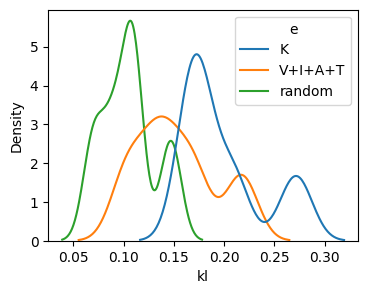

In [17]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

dct_df = pd.DataFrame(dct)
plt.figure(figsize=(4, 3))
sns.kdeplot(dct_df, x="kl", hue="e", bw_adjust=0.5)

<Axes: xlabel='d', ylabel='Density'>

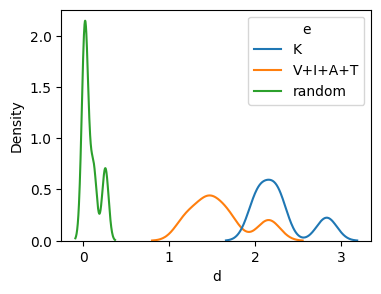

In [18]:
plt.figure(figsize=(4, 3))
sns.kdeplot(dct_df, x="d", hue="e", bw_adjust=0.5)

Text(0.5, 1.0, 'n_generate=1000')

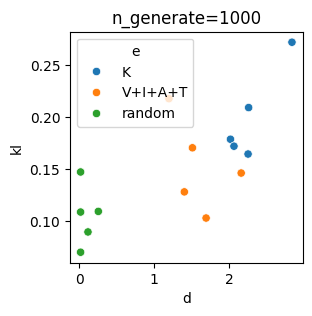

In [19]:
plt.figure(figsize=(3, 3))
sns.scatterplot(dct_df, x="d", y="kl", hue="e")
plt.title("n_generate=1000")

# Regex enzyme

In [1]:
from disassembly.simulate_proteolysis_regex import ProteolysisSimulator, Enzyme

ps = ProteolysisSimulator()
hbb = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
pr39 = "METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR"
thrb = "MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE"
actb = "MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF"
chymotrp_regex = Enzyme("chymotrypsin", [("(.)(.)([F|Y|W|M])([^P])(.)(.)(.)", 1)])
protein_sequences = []
true_distributions = []
for seq in [actb, hbb, pr39, thrb]:
    true_distribution = ps.simulate_proteolysis(
        seq, enzyme=chymotrp_regex, n_generate=500, graph=False
    )
    protein_sequences.append(seq)
    true_distributions.append(true_distribution)
protein_sequences

 499 / 500 (589)
145 unique peptides. 510 total
 498 / 500 (631)
88 unique peptides. 510 total
 499 / 500 (632)
80 unique peptides. 510 total
 499 / 500 (606)
127 unique peptides. 510 total


['MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF',
 'MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH',
 'METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR',
 'MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNY

# Genetic algorithm to get cleavage spec

In [2]:
from disassembly.estimate_parameters_ga import ParameterEstimatorGA

pega = ParameterEstimatorGA(
    true_distributions,
    protein_sequences,
    n_individuals=30,
    mutation_rate=0.05,
    kill_fraction=0.5,
    n_generate=50,
    length_penalty=0.1,
)

pega.run(n_generations=20, temp_start=0, temp_end=2)

Computing baseline fitnesses for all protein sequences...
---
Running GA...
---
33:(.)(.)([M])(.)(.)(.) 1 (.)(.)([Y])(.)(.)(.) 1  0.4557440471272042
31
56:(.)(.)([F])(.)(.)(.) 1 (.)(.)([M])(.)(.)(.) 1  0.4348771265387518
31
61:(.)(.)([Y])(.)(.)(.) 1 (.)(.)([F])(.)(.)(.) 1  0.5352754305002652
31
82:(.)(.)([F])(.)(.)(.) 1 (.)([D])([F])(.)(.)(.) 1 (.)(.)([W])(.)(.)(.) 1  0.48202100348342697
31
97:(.)(.)([W])(.)(.)(.) 1 (.)(.)([M])(.)(.)(.) 1 (.)(.)([M])([^A])([^M])(.) 1 (.)(.)([F])(.)(.)(.) 1 (.)(.)([Y])(.)(.)(.) 1  0.6506648737016029
31
118:(.)(.)([F|R])([S])(.)(.) 1 (.)(.)([Y])(.)(.)(.) 1 (.)(.)([W])(.)(.)(.) 1 (.)(.)([M])(.)(.)([^D]) 1 (.)(.)([F])(.)(.)(.) 1 (.)([^A])([Y])(.)(.)(.) 1  0.4796890388250541
31
136:(.)(.)([F])(.)(.)(.) 1 (.)(.)([M])(.)(.)(.) 1 (.)(.)([Y])(.)(.)([^N]) 1 (.)(.)([W])(.)(.)(.) 1 (.)(.)([A])([Y])([T])(.) 1 (.)(.)([W])([^W])(.)(.) 1 (.)(.)([Y])(.)(.)(.) 2  0.3865242975197168
31
121:(.)(.)([F])(.)(.)(.) 1 (.)(.)([Y])(.)(.)(.) 1 (.)(.)([W])(.)(.)(.) 1 (.)(.)([A])([

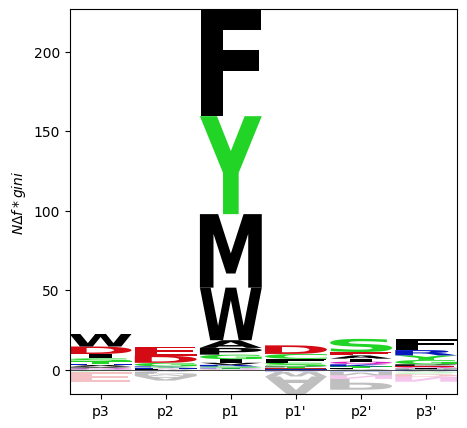

In [14]:
pega.plot(topn=500)

<Axes: xlabel='level_0', ylabel='0'>

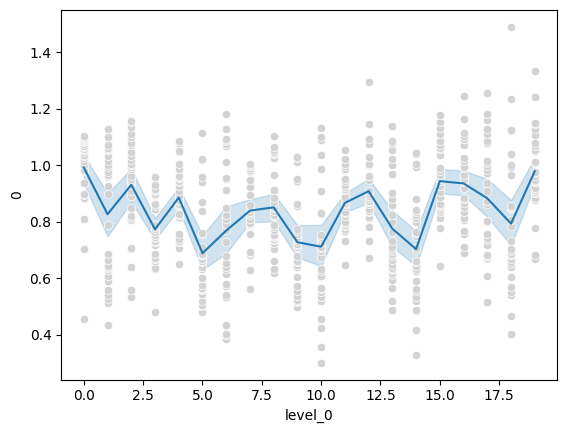

In [4]:
import pandas as pd
import seaborn as sns

sns.lineplot(pd.DataFrame(pega.fitness).T.stack().reset_index(), x="level_0", y=0)
sns.scatterplot(
    pd.DataFrame(pega.fitness).T.stack().reset_index(),
    x="level_0",
    y=0,
    color="lightgray",
)

<Axes: >

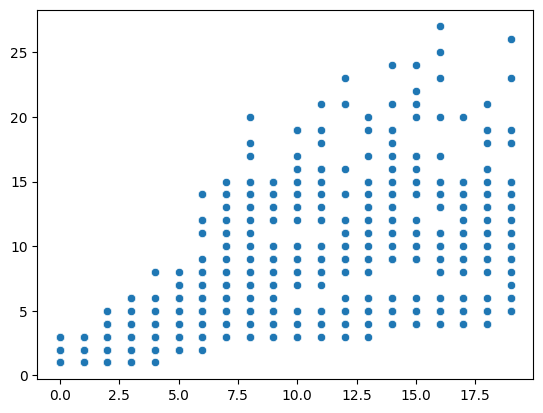

In [5]:
id_len = [(x[0], len(x[1].rules)) for x in pega.all_results.keys()]
sns.scatterplot(x=[x[0] for x in id_len], y=[x[1] for x in id_len])